In [36]:
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from sklearn.metrics import mean_absolute_percentage_error as mape
from all_functions import *
import os
from aeon.clustering.averaging import elastic_barycenter_average
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from VotingCombination import VotingCombination
from dateutil.relativedelta import relativedelta
from sklearn.svm import SVR
import os
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter
warnings.filterwarnings("ignore")
%matplotlib inline

def get_predictions_csv(path, format, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    params = {}
    # for format in formats:
    filtered_df = df[df['DATA'] == format]
    
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    
    # values_list = columns_p1_to_p12.values.tolist()
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    params = filtered_df['PARAMS'].iloc[0]
            
    return results, params

def get_params_model(caminho_arquivo, test_date):
    df = pd.read_csv(caminho_arquivo, sep=';')
    
    df_filtrado = df[df['test_date'] == test_date]
    params_dict = ast.literal_eval(df_filtrado['PARAMS'].iloc[0])
    
    return params_dict

def convert_to_list(series_str):
    return eval(series_str)

def get_preds_hybrid(path, test_date, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['test_range'] == test_date]
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    return results

def get_error_series(path, limit_date):
    df = pd.read_csv(path, sep=";")
    error_series_str = df.loc[df['test_range'] == limit_date, 'error_series'].values[0]
    error_list_rf = ast.literal_eval(error_series_str)
    return error_list_rf

def save_csv(nome, csv_file, uf, derivado, models, series, test, preds, horizon=12, window=12):
    y_baseline = series[-horizon*2:-horizon].values
    rmse_result = rmse(test, preds)
    mape_result = mape(test, preds)
    pocid_result = pocid(test, preds)
    pbe_result = pbe(test, preds)
    mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
    mase_result = mase(test, preds, y_baseline)

    df_result = pd.DataFrame({'DATA': nome, 'UF': uf, 'PRODUCT': derivado, 'MODEL':  f"{'_'.join(models)}", 'PARAMS': str({}), 'WINDOW': window, 'HORIZON': horizon,  
                                            'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result, 'MASE': mase_result,
                                            'P1': preds[0], 'P2': preds[1], 'P3': preds[2], 'P4': preds[3], 'P5': preds[4],
                                            'P6': preds[5], 'P7': preds[6], 'P8': preds[7], 'P9': preds[8], 'P10': preds[9],
                                            'P11': preds[10], 'P12': preds[11]
                                            }, index=[0])
    df_result.to_csv(csv_file, sep=';', mode='a', header=False, index=False)


def combination_all_time(erros_dict, predicoes_dict):
    n_pontos_erro = len(next(iter(erros_dict.values())))  
    intervalo = 12  
    n_intervalos = n_pontos_erro // intervalo  

    combinacao_predicoes = []
    ponderacoes_por_ponto = []

    for i in range(intervalo):  
        pesos_intervalo = {modelo: 0 for modelo in erros_dict}

        for j in range(n_intervalos): 
            idx = j * intervalo + i  

            erros_ponto = {modelo: abs(float(erros_dict[modelo][idx])) for modelo in erros_dict}
            menor_erro = min(erros_ponto.values())
            
            for modelo in erros_dict:
                if erros_ponto[modelo] == menor_erro:
                    pesos_intervalo[modelo] += 1
                else:
                    pesos_intervalo[modelo] += menor_erro / erros_ponto[modelo]
        
        soma_pesos_intervalo = sum(pesos_intervalo.values())
        pesos_normalizados_intervalo = {modelo: peso / soma_pesos_intervalo for modelo, peso in pesos_intervalo.items()}
        
        predicao_combinada = sum(pesos_normalizados_intervalo[modelo] * predicoes_dict[modelo][i] for modelo in predicoes_dict)
        
        combinacao_predicoes.append(predicao_combinada)
        ponderacoes_por_ponto.append(pesos_normalizados_intervalo)
    
    return combinacao_predicoes, ponderacoes_por_ponto


def combination_val(erros_dict, predicoes_dict):
    n_pontos = len(next(iter(erros_dict.values())))
    combinacao_predicoes = []
    ponderacoes_por_ponto = []

    for i in range(n_pontos):
        pesos = {
            modelo: 1 / abs(float(erros_dict[modelo][i])) 
            for modelo in erros_dict
        }
        
        soma_pesos = sum(pesos.values())
        pesos_normalizados = {modelo: peso / soma_pesos for modelo, peso in pesos.items()}
        
        predicao_combinada = sum(pesos_normalizados[modelo] * predicoes_dict[modelo][i] for modelo in predicoes_dict)
        
        combinacao_predicoes.append(predicao_combinada)
        ponderacoes_por_ponto.append(pesos_normalizados)
    
    return combinacao_predicoes, ponderacoes_por_ponto


def generate_index(start_date, end_date):
    end_date_dt = pd.to_datetime(end_date)
    
    start_date_dt = pd.to_datetime(start_date)
    
    index = pd.period_range(start=start_date_dt, end=end_date_dt, freq='M')

    return index

def get_test_real(series, start_date, end_date):
    start_period = pd.to_datetime(start_date).to_period('M')
    end_period = (pd.to_datetime(end_date))
    
    filtered_series = series.loc[start_period:end_period]

    return filtered_series

def get_train_real(series, start_date):
    start_period = pd.to_datetime(start_date).to_period('M')
    
    filtered_series = series[series.index < start_period]

    return filtered_series


def get_all_error_series(path, limit_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= limit_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_concatenated = []
    for _, row in df_filtered.iterrows():
        error_series_str = row['error_series']
        error_list = ast.literal_eval(error_series_str)
        error_series_concatenated.extend(error_list)
    
    return error_series_concatenated



def get_all_error_series_weight(path, limit_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= limit_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_weighted = []
    total_rows = len(df_filtered)
    
    for idx, row in enumerate(df_filtered.iterrows()):
        error_series_str = row[1]['error_series']
        error_list = ast.literal_eval(error_series_str)
        
        weight = (idx + 1) / total_rows
        
        error_series_weighted.append((weight, error_list))
    
    return error_series_weighted

def combination_all_time_weighted(erros_dict, predicoes_dict):
    janelas = len(next(iter(erros_dict.values())))
    pontos = 12
    
    combinacao_predicoes = [0] * pontos
    ponderacoes_por_ponto = [0] * pontos


    for i in range(pontos):
        pontuacao_modelo = {}


        for j in range(janelas):
            modelo_ponto = {}

            #percorro os modelos pegando a mesma janela e mesmo ponto
            for modelo in erros_dict:
                ponto_i = erros_dict[modelo][j][1][i]
                peso_intervalo = erros_dict[modelo][j][0] # sempre sera o mesmo para todos os modelos nessa janela
                modelo_ponto[modelo] = ponto_i

            chave_menor_erro = min(modelo_ponto, key=modelo_ponto.get)
            menor_erro = modelo_ponto[chave_menor_erro]

            #para cada modelo pontuo os pontos de acordo com o melhor (minimo)
            for modelo in erros_dict:
                if modelo not in pontuacao_modelo:
                    pontuacao_modelo[modelo] = 0
                #melhor modelo no ponto i na janela j
                if modelo_ponto[modelo] == menor_erro:
                    pontuacao_modelo[modelo] += 1 * peso_intervalo
                else:
                    penalizacao = 1 - ((modelo_ponto[modelo] - menor_erro) / modelo_ponto[modelo])
                    if penalizacao < 0:
                        penalizacao = 0
                    pontuacao_modelo[modelo] += penalizacao * peso_intervalo
                    # pontuacao_modelo[modelo] += (menor_erro / modelo_ponto[modelo]) * peso_intervalo
            
        #realizar a media ponderada de acordo com o valor do peso de cada modelo em modelo_ponto.
        #combinar predicoes para cada ponto i de acordo com o peso estabelecdo em modelo_ponto para o modelo
        soma_pontuacoes = sum(pontuacao_modelo.values())
        if soma_pontuacoes == 0:
            soma_pontuacoes = 1 
            
        combinacao_ponto = 0
        for modelo in predicoes_dict:
            peso_modelo = pontuacao_modelo.get(modelo, 0)
            previsao_modelo = predicoes_dict[modelo][i]
            combinacao_ponto += peso_modelo * previsao_modelo
        
        combinacao_predicoes[i] = combinacao_ponto / soma_pontuacoes
        ponderacoes_por_ponto[i] = soma_pontuacoes


    return combinacao_predicoes, ponderacoes_por_ponto


In [37]:
transformations = ["normal", "deseasonal", "log"]
models = ["knn", "rf", "deepar", "svr", "catboost", "arima"]
noResid = True
val_date = '2017-03_2018-02'
test_date = '2019-03_2020-02'
results_file = f'./combination/dynamic_time_weight_2/{test_date}'
horizon = 12
window = 12

dirs = [
    '../datasets/venda/mensal/uf/gasolinac/',
    '../datasets/venda/mensal/uf/etanolhidratado/',
    '../datasets/venda/mensal/uf/glp/',
    '../datasets/venda/mensal/uf/oleodiesel/',
    # '../datasets/venda/mensal/uf/querosenedeaviweightacao/',
]
colunas = ['DATA', 'UF', 'PRODUCT', 'MODEL', 'PARAMS', 'WINDOW', 'HORIZON', 'RMSE', 'MAPE', 'POCID', 'PBE', 'MASE',
           'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12',
           ]

start_date, end_date = test_date.split('_')
test_index = generate_index(start_date, end_date)
for directory in dirs:
    for file in os.listdir(directory) :
        if file.endswith('.csv'):
            uf = file.split("_")[1].upper()
            derivado = file.split("_")[2].split(".")[0]
            if derivado != 'etanolhidratado' and uf != 'RR':
                full_path = os.path.join(directory, file)
                series = read_series(full_path)
                _, _ = train_test_stats(series, horizon)
                test_real = get_test_real(series, start_date, end_date)

                predictions = {}
                preds_elastic = []
                preds_barycenter = []
                error_models = {}
                
                for model in models:
                    for transform in transformations:
                        series_preds = get_preds_hybrid(f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', test_date, test_index)
                        # error_serie = get_error_series(f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', val_date) # unica da validacao

                        # error_serie = get_all_error_series(f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', val_date) #acumula todas janelas de erro em ordem
                        error_serie = get_all_error_series_weight(f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', val_date) # adiciona peso maior pra recentes


                        error_models[f'{model}_{transform}'] = error_serie
                        predictions[f'{model}_{transform}'] = series_preds
                        preds_elastic.append(np.array([[series_preds.values]]))
                        preds_barycenter.append(series_preds.values)
                    
                        if noResid:
                            try:
                                series_noresid = get_preds_hybrid(f'./results/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', test_date, test_index)
                                # error_serie = get_error_series(f'./results/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', val_date)  # unica da validacao
                                
                                # error_serie = get_all_error_series(f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', val_date) #acumula todas janelas de erro em ordem

                                error_serie = get_all_error_series_weight(f'./results/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', val_date) # adiciona peso maior pra recentes
                                error_models[f'{model}_noresid_{transform}'] = error_serie             
                                predictions[f'{model}_noresid_{transform}'] = series_noresid
                                preds_elastic.append(np.array([[series_noresid.values]]))
                                preds_barycenter.append(series_noresid.values)
                            except:
                                print(uf)
                                print(model)
                                print(derivado)
                                print(transform)
                                raise ValueError('error')
                            # print(len(next(iter(error_models.values()))))

                # voting = VotingCombination(predictions, combination='median')
                # preds_median = voting.predict()

                preds_dynamic, pond = combination_all_time_weighted(error_models, predictions)
                path_derivado = results_file + f'/{derivado}'
                csv_file = path_derivado + f"/transform_{uf.upper()}.csv"
                os.makedirs(path_derivado, exist_ok=True)
                if not os.path.exists(csv_file):
                    pd.DataFrame(columns=colunas).to_csv(csv_file, sep=';', index=False)

                # save_csv("mean", csv_file, uf, derivado, models, series, test_real, preds_dynamic, horizon, window)

                # voting = VotingCombination(predictions, combination='mean')
                # preds_median = voting.predict()
        
                # save_csv("mean", csv_file, uf, derivado, models, series, test_real, preds_median, horizon, window)

            # voting = VotingCombination(predictions, combination='mean')
            # preds_mean = voting.predict()
            # save_csv("mean",csv_file, uf, derivado, models, series, test_real, preds_mean, horizon, window)

            # preds_softdtw = softdtw_barycenter(preds_barycenter, max_iter=35, gamma=0.01)
            # preds_softdtw = pd.Series(preds_softdtw.flatten().tolist(), index=test_real.index)
            # save_csv("softdtw_barycenter",csv_file, uf, derivado, models, series, test_real, preds_softdtw, horizon, window)

            # preds_dtw_subgradient = dtw_barycenter_averaging_subgradient(preds_barycenter, max_iter=35)
            # preds_dtw_subgradient = pd.Series(preds_dtw_subgradient.flatten().tolist(), index=test_real.index)
            # save_csv("DBA_subgradient", csv_file, uf, derivado, models, series, test_real, preds_dtw_subgradient, horizon, window)

            # preds_dtw_avg = dtw_barycenter_averaging(preds_barycenter, max_iter=35)
            # preds_dtw_avg = pd.Series(preds_dtw_avg.flatten().tolist(), index=test_real.index)
            # save_csv("DBA", csv_file, uf, derivado, models, series, test_real, preds_dtw_avg, horizon, window)

            # capt = np.vstack(preds_elastic)
            # elastic = elastic_barycenter_average(capt, distance="twe", reach=15)
            # preds_elastic = pd.Series(elastic[0].tolist(), index=test_real.index)
            # save_csv("EBA_twe", csv_file, uf, derivado, models, series, test_real, preds_elastic, horizon, window)


2416.221858963997
3452.3049954542043
769.7670306101754
508.14607082119926
515.4458104347005
1492.5675509387731
1543.116338568106
719.7071322198532
1571.0680280691201
407.2646371432857
904.1317128170809
1174.078939079648
3162.930264837328
5658.723079305892
1314.238330689799
1229.3449698467523
953.5311916564564
520.8715218541158
1412.4099862837184
963.6176192018638
794.9817477901066
588.5980575540071
946.8099808152132
1644.3158578153198
2137.789020583085
1031.7938037901472
903.6827590613635
1273.3501133950501
418.73655048407915
722.53809123177
677.5384717803659
3036.906644780619
760.2570970551017
710.6746440079933
684.443257164733
1963.06897816831
2117.127922512313
2207.7247297690956
576.3722340775798
91450.38873686615
975.2821292269207
1007.8167324331522
573.3923445992565
668.6782321863759
2345.8948229887274
716.2489147508146
882.580983494819
3644.4236570368485
591.3315345618063
881.9157922560281
2199.628276998063
721.7271190251263
1165.0136137135323
515.9608295588281
762.8751759566401


In [38]:
derivado = 'oleodiesel'
estado = 'SP'
test_date = '2019-03_2020-02'
start_date, end_date = test_date.split('_')
test_index = generate_index(start_date, end_date)

series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')

comb_weight, _ = get_predictions_csv(f'./combination/dynamic_time_weight_2/{test_date}/{derivado}/transform_{estado}.csv', "mean", test_index)
comb_static, _ = get_predictions_csv(f'./combination/static/{test_date}/{derivado}/transform_{estado}.csv', "mean", test_index)

test_serie = get_test_real(series, start_date, end_date)

plot_series(comb_weight,test_serie,comb_static, labels=["Combinacao do tempo", "Teste", "STATIC"] )

ValueError: Length of values (0) does not match length of index (12)

oleodiesel
SP


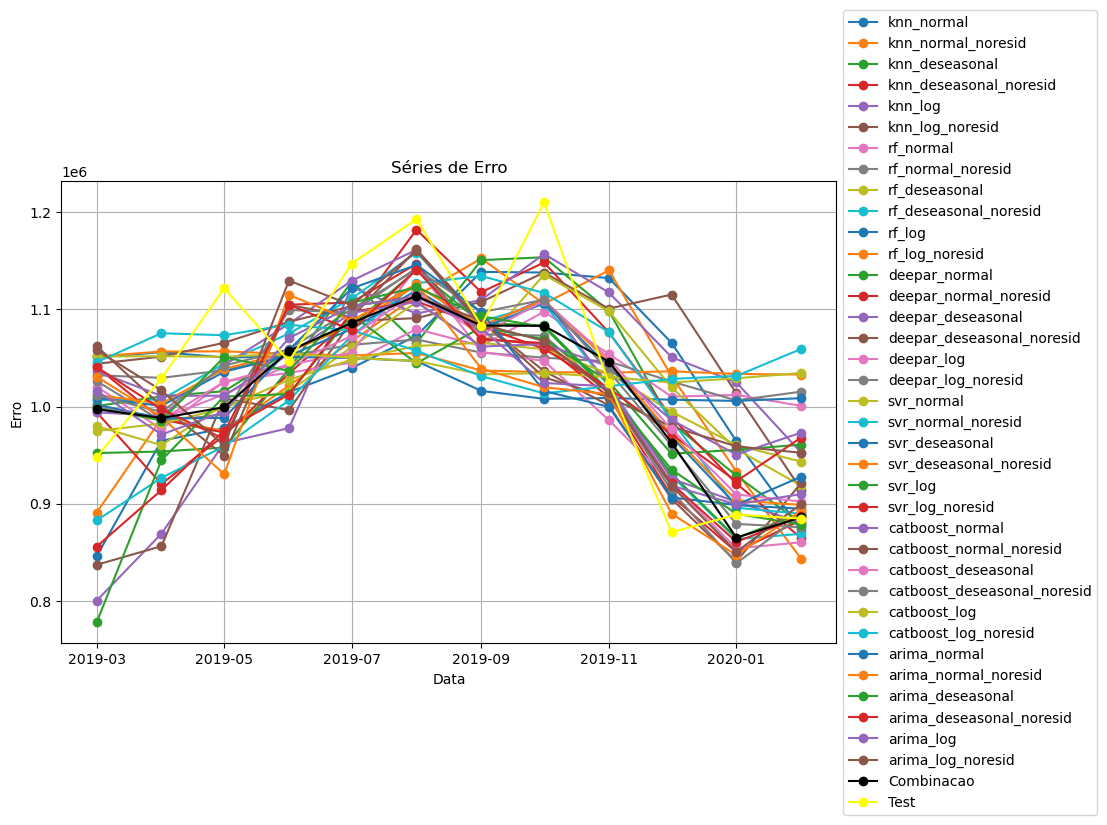

In [26]:
print(derivado)
print(estado)
series_erro = {}
for model in models:
    for transform in transformations:
        file_path = f'./results/{model}/{derivado}/{transform}/transform_{estado}.csv'
        serie_erro = get_preds_hybrid(file_path, test_date, test_index)
        key = f"{model}_{transform}"
        series_erro[key] = serie_erro

        file_path = f'./results/{model}_noresid/{derivado}/{transform}/transform_{estado}.csv'
        serie_erro = get_preds_hybrid(file_path, test_date, test_index)
        key = f"{model}_{transform}_noresid"
        series_erro[key] = serie_erro


plt.figure(figsize=(10, 6))  # Criar um único gráfico

for key, serie in series_erro.items():
    plt.plot(serie.index.to_timestamp(), serie.values, marker='o', label=key)

plt.plot(comb_weight.index.to_timestamp(), comb_weight.values, marker='o',color='black', label='Combinacao')
plt.plot(test_serie.index.to_timestamp(), test_serie.values, marker='o',color='yellow', label='Test')
plt.title("Séries de Erro")
plt.xlabel("Data")
plt.ylabel("Erro")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()